# Comparison 2D

Comparison of algorithms provided in `localthickness` module with other algorithms. In particular, we compare with the conventional algorithm which uses dilation with discs of increasing radius (and is therefore painfully slow). This  serves as groundt truth. We also compare with the results of the algorithm from the [porespy](https://porespy.org/) package, [local_thickness](https://porespy.org/modules/generated/generated/porespy.filters.local_thickness.html). In 2D, we don't compare with [BoneJ](https://bonej.org/), as it requires 3D image.

This notebook is primarily intended to be **wieved** to check how our algorithms compare with other algorithms, in terms of run time and the quality of output. If you want to **run** the notebook, be aware that the conventional algorithm (which is here used as ground truth) takes a long time to run (204 sec), while `porespy` needs to be installed, and may require fixing a problem with `ipywidgets` as described bellow. 


Porespy uses `tqdm` which in notebook setting uses `ipwidgets`, and I had problems running it; The error was
```
cannot import name 'IProgress' from 'ipywidgets'
```
Running the next cell fixed the problem.

In [1]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [2]:
import skimage.io
import matplotlib.pyplot as plt
import localthickness as lt
import porespy as ps
import time
import numpy as np

In [3]:
filename = 'data/test_2D_s.png'
B = skimage.io.imread(filename, as_gray = True) > 0.5  # Change to '<' to measure separation

In [4]:
methods = {
    'Conventional': lt.local_thickness_conventional,  # Conventional algorithm, this serves as ground truth.
    'Fast': lt.local_thickness,
    'Scaled 0.5': lambda B: lt.local_thickness(B, scale=0.5),
    'PoreSpy': ps.filters.local_thickness
    }

In [5]:
runtimes = {}
results = {}

print('Running conventional algorithm may take long time!')
for methodname in methods.keys():
    print(f'Processing using {methodname} method. ', end='')
    start_time = time.time()
    results[methodname] = methods[methodname](B)
    runtimes[methodname] = time.time() - start_time
    print(f'Runtime {runtimes[methodname]}.')

Running conventional algorithm may take long time!
Processing using Conventional method. Runtime 194.90190196037292.
Processing using Fast method. Runtime 0.1407177448272705.
Processing using Scaled 0.5 method. Runtime 0.04347801208496094.
Processing using PoreSpy method. 

  0%|          | 0/25 [00:00<?, ?it/s]

Runtime 0.2520267963409424.


In [6]:
maxval = results['Conventional'].max()
edges = np.linspace(0, maxval, 31)
histograms = {}
cumsums = {}
for methodname in methods.keys():
    histograms[methodname] = np.histogram(results[methodname][B], edges)[0]
    cumsums[methodname] = np.cumsum(histograms[methodname])

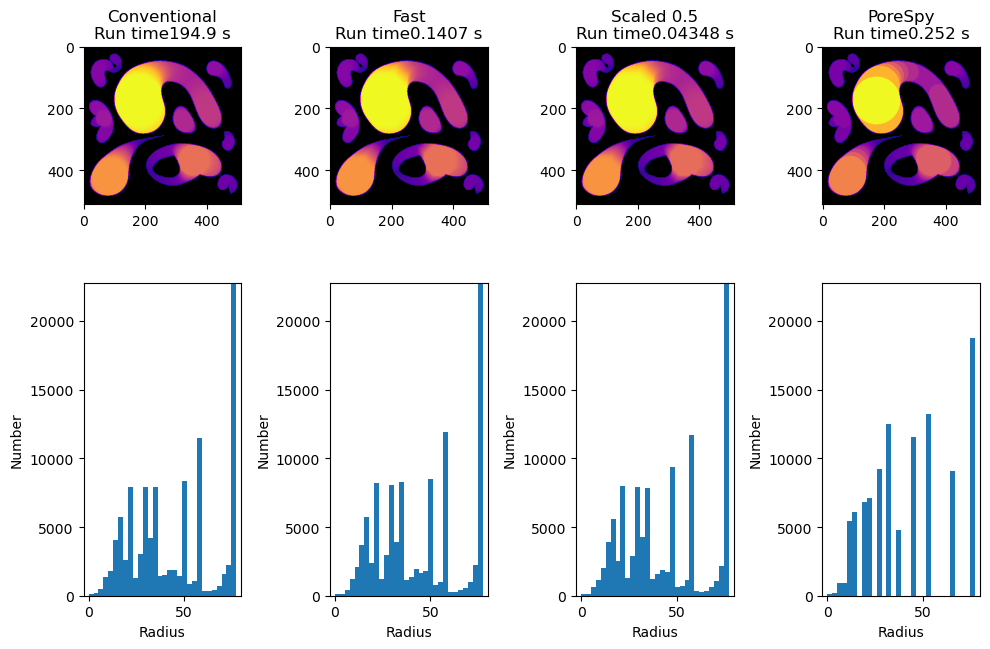

In [7]:
# Visualization.
fig, ax = plt.subplots(2, len(methods), figsize=(10, 7))

for ai, ah, methodname in zip(ax[0], ax[1], methods):
    ai.imshow(results[methodname], vmin=0, vmax=maxval, cmap=lt.black_plasma())
    ai.set_title(f'{methodname}\nRun time{runtimes[methodname]:0.4} s')
    ah.bar(0.5*(edges[1:] + edges[:-1]), histograms[methodname], width=edges[1])
    ah.set_xlim([-edges[1], maxval + edges[1]])
    ah.set_ylim([0, histograms['Conventional'].max()])
    ah.set_xlabel('Radius')
    ah.set_ylabel('Number')
plt.tight_layout()

plt.show()


###### Conclusion
In terms of quality (visually and by considering the histogram of values), our result without scalling is very similar to the conventional (ground truth) result. Using scaling influences the result only slightly. Result of porespy algorithm returns discrete values. Porespy does allow the user to decide how many values to consider (default is 25), so porespy result can be improved, but that would influence run time. 
In terms of run time, our algorithm without scaling is slightly faster than porespy. With scaling our algorithm is much faster. 

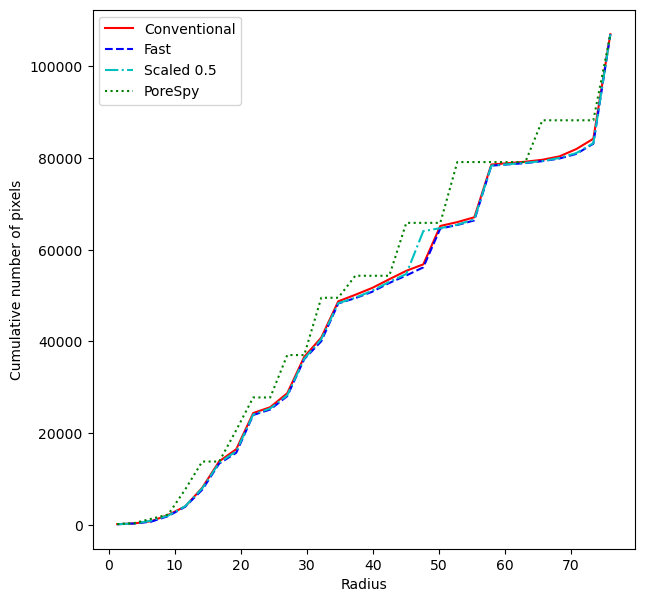

In [8]:
# Visualization.
fig, ax = plt.subplots(figsize=(7, 7))
[ax.plot(0.5*(edges[1:] + edges[:-1]), cs, line) for cs, line in 
        zip(cumsums.values(), ['r', 'b--', 'c-.', 'g:'])];
ax.legend(cumsums.keys()) 
ax.set_xlabel('Radius')
ax.set_ylabel('Cumulative number of pixels')
plt.show()

###### Conclusion
Our results are close to ground truth, especially without scalling. It seems that porespy underestimates local thickness, while we slightly overestimate.

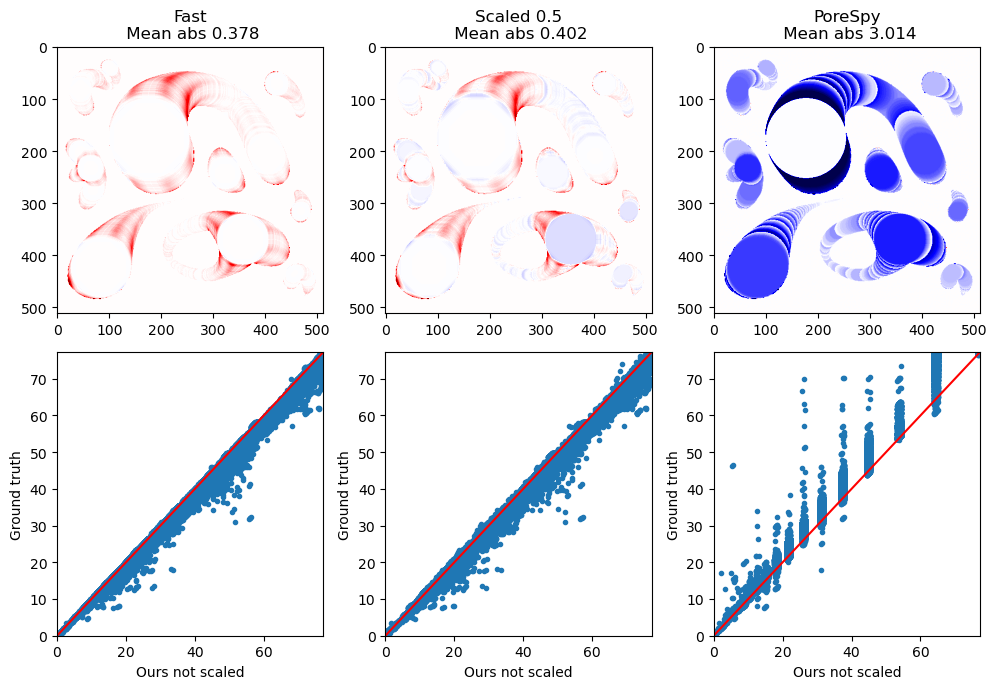

In [9]:
# Compute difference in respect to conventianal and Visualize.
val = 10  # colormap limits
fig, ax = plt.subplots(2, 3, figsize=(10, 7))
noise = np.random.random(size=B.sum()) - 0.5  # for a tinly bit of pertrubation

for ai, ah, methodname in zip(ax[0], ax[1], list(methods.keys())[1:]):
    diff = results[methodname] - results['Conventional']
    ai.imshow(diff, vmin=-val, vmax=val, cmap=plt.cm.seismic)
    ai.set_title(f'{methodname}\n Mean abs {abs(diff[B]).mean():0.3f}')
    ah.plot(results[methodname][B] + noise, results['Conventional'][B] + noise, '.')
    ah.plot([0, maxval], [0, maxval], 'r')
    ah.set_xlim([0, maxval])
    ah.set_ylim([0, maxval])
    ah.set_xlabel('Ours not scaled')
    ah.set_ylabel('Ground truth')

plt.tight_layout()
plt.show()


###### Conclusion
This confirms that we slightly overestimate local thickness, compared to ground truth. There are few pixels where error is large with the difference of up to 50. Scaled algorithm has similar issues, but also places where it underestimates, especially in regions of large local thickness. Porespy generally underestimates. Results of porespy are discrete.